Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


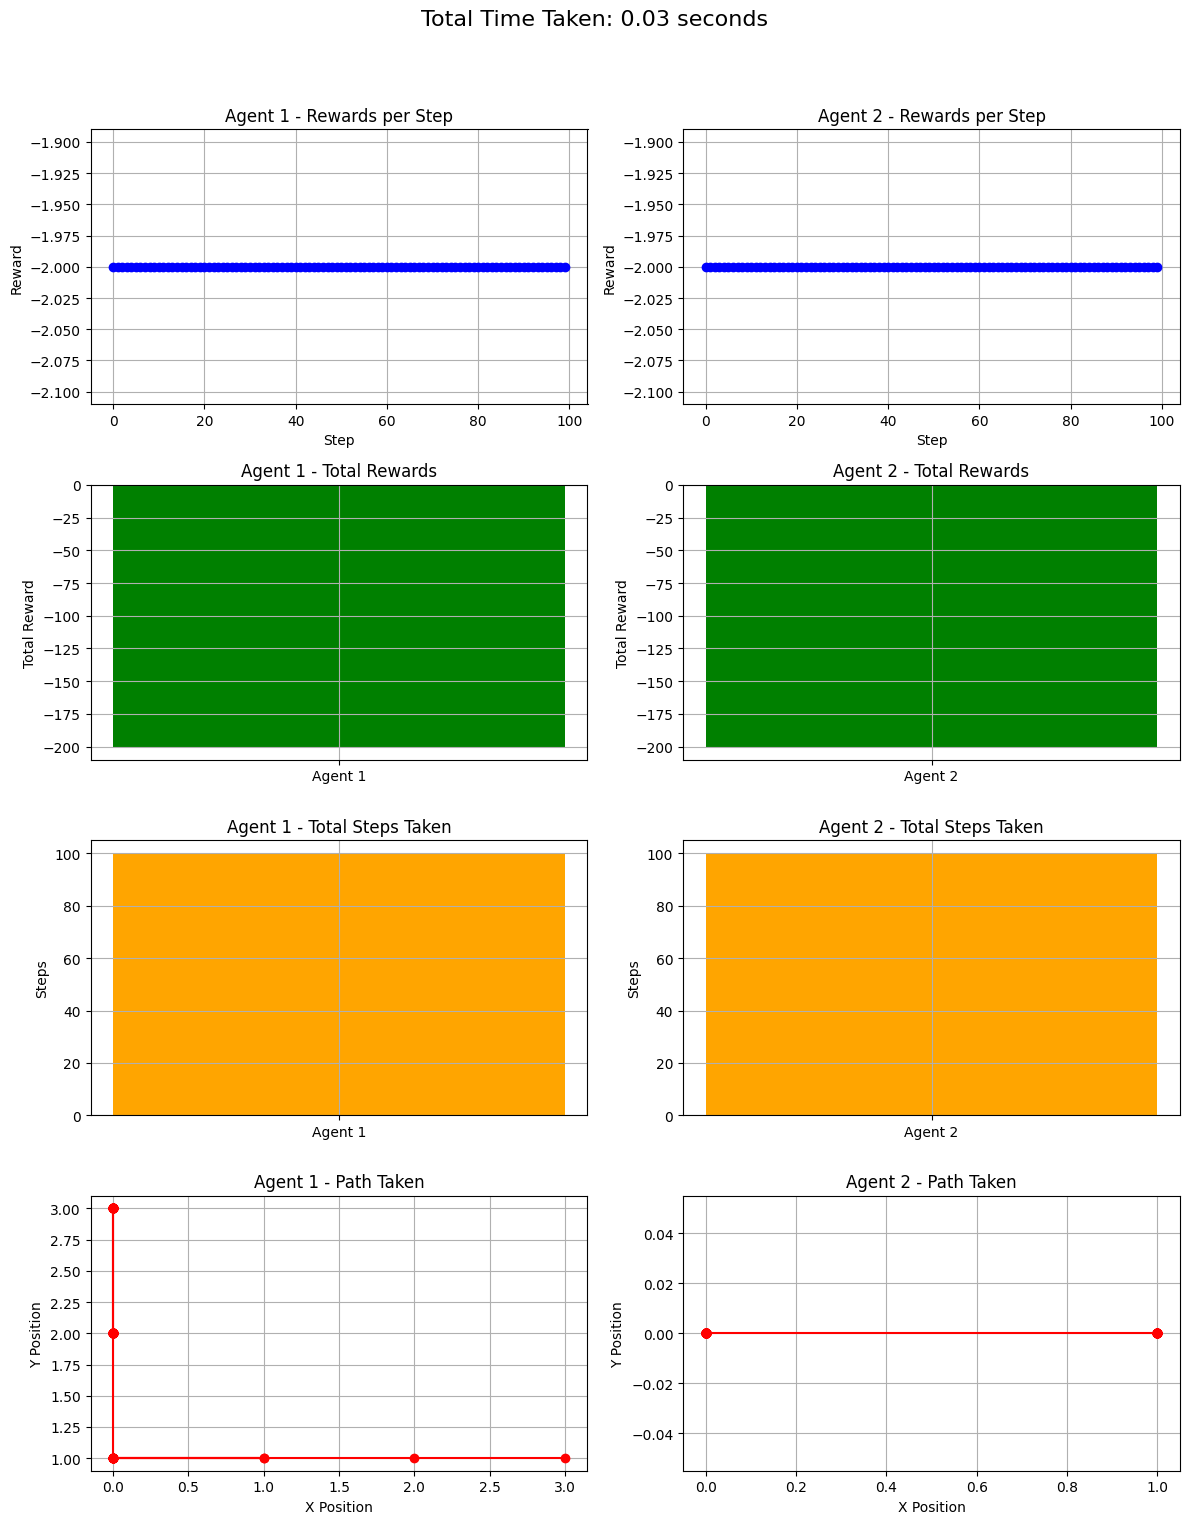

In [5]:
class MultiAgentWarehouseEnv(gym.Env):
    """Multi-Agent Environment where each agent has a unique goal and waits once it reaches the goal."""
    metadata = {'render.modes': ['human']}

    def __init__(self, rows, cols, num_agents, num_obstacles):
        super(MultiAgentWarehouseEnv, self).__init__()
        self.rows = rows
        self.cols = cols
        self.num_agents = num_agents
        self.num_obstacles = num_obstacles
        self.grid = np.zeros((rows, cols))  # Empty grid initialized

        self.obstacles = []  # Obstacles will be placed dynamically
        self.agents_pos = []  # List of agents' positions
        self.agents_goal = []  # List of agents' goals
        self.agents_done = [False] * num_agents  # Track whether each agent has reached its goal
        self.agents_prev_pos = [None] * num_agents  # Track previous positions to determine direction

        self.time_elapsed = 0  # Initialize the time_elapsed variable

        # Colors for each agent and their respective goals
        self.agent_colors = ['blue', 'red', 'purple', 'orange', 'yellow', 'cyan']
        self.goal_colors = ['green', 'pink', 'brown', 'magenta', 'lime', 'olive']

        # Flattened action space for DQN: total actions = number of agents * 5
        self.action_space = gym.spaces.Discrete(5 ** num_agents)  # Each agent has 5 actions

        # Observation space: each agent's (x, y) position and their goal's (x, y)
        self.observation_space = gym.spaces.Box(low=0, high=max(self.rows, self.cols),
                                            shape=(num_agents * 4,), dtype=np.int32)

        # Initialize environment with agents and obstacles
        self._place_dynamic_objects()

    def _place_dynamic_objects(self):
        """ Dynamically place agents, goals, and obstacles in the environment. """
        all_positions = [(x, y) for x in range(self.rows) for y in range(self.cols)]
        random.shuffle(all_positions)  # Shuffle to get random positions

        # Place obstacles
        self.obstacles = [all_positions.pop() for _ in range(self.num_obstacles)]
        for (x, y) in self.obstacles:
            self.grid[x][y] = -1  # Mark obstacles on the grid

        # Place agents and their goals
        self.agents_pos = [all_positions.pop() for _ in range(self.num_agents)]
        self.agents_goal = [all_positions.pop() for _ in range(self.num_agents)]

        # Reset agents_done and agents_prev_pos status
        self.agents_done = [False] * self.num_agents
        self.agents_prev_pos = [None] * self.num_agents

    def reset(self):
        """ Reset the environment by dynamically placing objects. """
        # Reset the grid
        self.grid = np.zeros((self.rows, self.cols))
        self._place_dynamic_objects()

        self.time_elapsed = 0  # Reset the time elapsed when the environment is reset

        # Return a concatenated observation of all agents' positions and goals
        return self._get_observation()

    def _get_observation(self):
        """ Concatenate agents' positions and goals into one observation vector. """
        obs = []
        for i in range(self.num_agents):
            obs.extend(self.agents_pos[i])  # Agent position (x, y)
            obs.extend(self.agents_goal[i])  # Agent goal (x, y)
        return np.array(obs, dtype=np.int32)

    def step(self, action):
        """ Execute one time step in the environment for all agents. """
        actions = self.decode_action(action)  # Decode the combined action into individual actions
        self.time_elapsed += 1  # Increment time elapsed at every step

        rewards = []
        done_list = []

        for i, action in enumerate(actions):
            if self.agents_done[i]:
                # If the agent has reached its goal, it waits (action = 4)
                action = 4

            x, y = self.agents_pos[i]
            self.agents_prev_pos[i] = (x, y)  # Save the current position as the previous one

            if action == 0:  # Forward
                new_pos = (x-1, y)
            elif action == 1:  # Reverse
                new_pos = (x+1, y)
            elif action == 2:  # Left
                new_pos = (x, y-1)
            elif action == 3:  # Right
                new_pos = (x, y+1)
            elif action == 4:  # Wait
                new_pos = (x, y)

            # Ensure the move is valid and doesn't result in collisions with other agents
            if self.is_valid_position(new_pos, i):
                self.agents_pos[i] = new_pos

            # Calculate reward
            reward = self.get_reward(i)
            rewards.append(reward)

            # Check if the agent reached the goal
            if self.agents_pos[i] == self.agents_goal[i]:
                self.agents_done[i] = True  # Mark agent as done
            done_list.append(self.agents_done[i])

        # Return the new concatenated observation, rewards, done status for each agent
        return self._get_observation(), np.sum(rewards), all(done_list), {}

    def decode_action(self, action):
        """ Decode a single action into individual actions for each agent. """
        actions = []
        for i in range(self.num_agents):
            actions.append(action % 5)  # Get the action for this agent
            action //= 5  # Move to the next agent's action
        return actions

    def is_valid_position(self, pos, agent_idx):
        """ Check if a position is valid (inside the grid, not an obstacle, and not occupied by another agent). """
        x, y = pos
        if not (0 <= x < self.rows and 0 <= y < self.cols):
            return False  # Out of bounds
        if self.grid[x][y] == -1:
            return False  # Obstacle
        # Check if any other agent is at the position
        for i, agent_pos in enumerate(self.agents_pos):
            if i != agent_idx and agent_pos == pos:
                return False  # Another agent is at the position
        return True

    def get_reward(self, agent_idx):
        """ Get the reward for the current position of an agent. """
        if self.agents_pos[agent_idx] == self.agents_goal[agent_idx]:
            return 100  # Reached destination
        elif self.agents_pos[agent_idx] in self.obstacles:
            return -10  # Hit an obstacle
        else:
            return -1  # Time penalty

    def render(self, mode='human'):
        """ Render the environment with agents represented as boxes with arrow heads indicating direction. """
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(5, 5))

        # Draw grid and obstacles
        for x in range(self.rows):
            for y in range(self.cols):
                ax.add_patch(Rectangle((y, x), 1, 1, fill=False, edgecolor='gray'))

        # Draw obstacles as black boxes
        for (x, y) in self.obstacles:
            ax.add_patch(Rectangle((y, x), 1, 1, color='black'))

        # Draw goals for each agent in green
        for i, (goal_x, goal_y) in enumerate(self.agents_goal):
            ax.add_patch(Rectangle((goal_y, goal_x), 1, 1, color='green'))

        # Draw agents as boxes with arrows showing direction
        for i, (agent_x, agent_y) in enumerate(self.agents_pos):
            # Change color to red if the agent has reached its goal
            color = 'blue' if not self.agents_done[i] else 'red'
            ax.add_patch(Rectangle((agent_y, agent_x), 1, 1, color=color))

            # Draw an arrow showing the direction of the agent
            direction = self.get_agent_direction(i)
            if direction == 0:  # Up
                ax.add_patch(Arrow(agent_y + 0.5, agent_x + 0.5, 0, 0.4, width=0.1, color='black'))
            elif direction == 1:  # Down
                ax.add_patch(Arrow(agent_y + 0.5, agent_x + 0.5, 0, -0.4, width=0.1, color='black'))
            elif direction == 2:  # Left
                ax.add_patch(Arrow(agent_y + 0.5, agent_x + 0.5, -0.4, 0, width=0.1, color='black'))
            elif direction == 3:  # Right
                ax.add_patch(Arrow(agent_y + 0.5, agent_x + 0.5, 0.4, 0, width=0.1, color='black'))

        ax.set_xlim(0, self.cols)
        ax.set_ylim(0, self.rows)
        ax.set_xticks(np.arange(0, self.cols + 1, 1))
        ax.set_yticks(np.arange(0, self.rows + 1, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.gca().invert_yaxis()  # Invert Y-axis to match grid coordinates
        plt.show()

    def get_agent_direction(self, agent_idx):
        """ Determine the direction an agent is moving based on its previous and current position. """
        if self.agents_prev_pos[agent_idx] is None:
            return -1  # No previous position, no direction

        prev_x, prev_y = self.agents_prev_pos[agent_idx]
        curr_x, curr_y = self.agents_pos[agent_idx]

        if curr_x < prev_x:
            return 0  # Up
        elif curr_x > prev_x:
            return 1  # Down
        elif curr_y < prev_y:
            return 2  # Left
        elif curr_y > prev_y:
            return 3  # Right
        return -1  # No movement

# Example of how to run the code
# Initialize the environment
env = MultiAgentWarehouseEnv(rows=5, cols=5, num_agents=2, num_obstacles=3)

# Initialize DQN model for multi-agent environment
model = A2C("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=10000)
model.save("DQN_MLP")

# Test the agents and collect the necessary data
total_rewards, steps, positions, rewards_per_step, total_time = test_agents(env, model)

# Visualize the results for both agents
visualize_agents_results(total_rewards, steps, positions, rewards_per_step, total_time)
